# Predicting Emotions in Twitter Sentiment Analysis part 3 - Bi-LSTM


# Import the data


In [191]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re as re

from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score, average_precision_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import confusion_matrix,classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Dense, LSTM, Conv1D, Embedding
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import save_model, load_model
from collections import Counter
from wordcloud import WordCloud

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

In [38]:
# use cleaned data from part 1 
data = pd.read_csv('../projects/cleanedtweets.csv')

In [39]:
data.head()

,label,text,text_emoticon,text_clean,text_pre,text_token,text_str,text_stem,text_lemm,is_equal
0,1,I LOVE @Health4UandPets u guys r the best!!,I LOVE @Health4UandPets u guys r the best!!,i love u guys r the best,i love u guys r the best,"['love', 'u', 'guys', 'r', 'best']",love u guys r best,love guys best,love u guys r best,True
1,1,im meeting up with one of my besties tonight! ...,im meeting up with one of my besties tonight! ...,im meeting up with one of my besties tonight c...,im meeting up with one of my besides tonight c...,"['im', 'meeting', 'one', 'besides', 'tonight',...",im meeting one besides tonight cant wait girl ...,meeting one besides tonight cant wait girl talk,im meeting one besides tonight cant wait girl ...,True
2,1,"@DaRealSunisaKim Thanks for the Twitter add, S...","@DaRealSunisaKim Thanks for the Twitter add, S...",thanks for the twitter add sunisa i got to me...,thanks for the twitter add punish i got to mee...,"['thanks', 'twitter', 'add', 'punish', 'got', ...",thanks twitter add punish got meet hin show dc...,thanks twitter add punish got meet hin show ar...,thanks twitter add punish got meet hin show dc...,True
3,1,Being sick can be really cheap when it hurts t...,Being sick can be really cheap when it hurts t...,being sick can be really cheap when it hurts t...,being sick can be really cheap when it hurts t...,"['sick', 'really', 'cheap', 'hurts', 'much', '...",sick really cheap hurts much eat real food plu...,sick really cheap hurts much eat real food plu...,sick really cheap hurts much eat real food plu...,True
4,1,@LovesBrooklyn2 he has that effect on everyone,@LovesBrooklyn2 he has that effect on everyone,he has that effect on everyone,he has that effect on everyone,"['effect', 'everyone']",effect everyone,effect everyone,effect everyone,True


In [40]:
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49682 entries, 0 to 49681
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   label          49682 non-null  int64 
 1   text           49682 non-null  object
 2   text_emoticon  49682 non-null  object
 3   text_clean     49682 non-null  object
 4   text_pre       49682 non-null  object
 5   text_token     49682 non-null  object
 6   text_str       49682 non-null  object
 7   text_stem      49682 non-null  object
 8   text_lemm      49682 non-null  object
 9   is_equal       49682 non-null  bool  
dtypes: bool(1), int64(1), object(8)
memory usage: 3.5+ MB


label            0
text             0
text_emoticon    0
text_clean       0
text_pre         0
text_token       0
text_str         0
text_stem        0
text_lemm        0
is_equal         0
dtype: int64

## Feature Extraction

### Split the data with train_test_split 

### Deep Learning: Intialise Word2vec and model with LTSM
Gogole trained model and is one of the most poppular technique to learn word embeddings using shallow neural network. 
but it is unable to ahdnel unknown or out-of-vocab words. If the model has not encountered the word, it will be forced to use a random vector. 
https://blog.slavv.com/37-reasons-why-your-neural-network-is-not-working-4020854bd607

https://medium.com/swlh/sentiment-classification-using-word-embeddings-word2vec-aedf28fbb8ca

https://www.districtdatalabs.com/modern-methods-for-sentiment-analysis#:~:text=Word2Vec%20Example%20in%20Python&text=It's%20clear%20from%20the%20above,in%20our%20case%20sentiment%20analysis.

https://trainings.analyticsvidhya.com/courses/course-v1:AnalyticsVidhya+NLP101+2018_T1/about?utm_source=blog&utm_medium=hands-on-sentiment-analysis-dataset-python/

In [41]:
X = data['text_stem']
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
X_train

5201     oooooh feels good outside kinda chill grab jacket
17933                          hey never thought yes smart
11475                               darling gap part speak
28617                             sixty job often nice one
24878    put vacation photos online yrs ago crashed for...
                               ...                        
11284    worry noone got one next question starts minut...
44732    glad everything html articles settled like fin...
38158    fell asleep watching young ones woke missed br...
860      got package wow excited one plant pot water ti...
15795                                       glad happy new
Name: text_stem, Length: 39745, dtype: object

In [43]:
Embedding_dimensions=300
# create word2vec training dataset
word2vec_train_data = list(map(lambda x: x.split(), X_train))

In [44]:
word2vec_train_data

[['oooooh', 'feels', 'good', 'outside', 'kinda', 'chill', 'grab', 'jacket'],
 ['hey', 'never', 'thought', 'yes', 'smart'],
 ['darling', 'gap', 'part', 'speak'],
 ['sixty', 'job', 'often', 'nice', 'one'],
 ['put',
  'vacation',
  'photos',
  'online',
  'yrs',
  'ago',
  'crashed',
  'forget',
  'name',
  'site'],
 ['sad', 'guy', 'like', 'offline'],
 ['miss', 'joey'],
 ['back',
  'montreal',
  'missing',
  'sun',
  'ocean',
  'desert',
  'good',
  'looking',
  'boys',
  'hey',
  'least',
  'ive',
  'got',
  'awesome',
  'friends'],
 ['good', 'night', 'michelle'],
 ['hand', 'hurts', 'playing', 'much', 'last', 'night'],
 ['miley',
  'sleep',
  'common',
  'like',
  'hours',
  'till',
  'waned',
  'waned',
  'time',
  'mean',
  'time',
  'watch',
  'tru',
  'confessions'],
 ['yeah', 'almost', 'forgot', 'thanks', 'reminder', 'cant', 'wait'],
 ['huzzah', 'love', 'much', 'superhero', 'paraphernalia'],
 ['wondering', 'darling'],
 ['cant',
  'get',
  'kristen',
  'stewart',
  'add',
  'lol',
  

In [45]:
# use cgram which is the default 
word2vec_model = Word2Vec(
    word2vec_train_data,
    vector_size= Embedding_dimensions, #dimensionality of vector for each word in vocab usually 100. try 300-500
    window=10,
    min_count = 2,# no of context words you are looking at   
    workers=4 # no of threads being used
)
print('Vocabulary length:', len(word2vec_model.wv.key_to_index))

Vocabulary length: 10759


In [46]:
word2vec_model.wv.most_similar('bad')

[('mood', 0.9958454966545105),
 ('goes', 0.9952408075332642),
 ('lovely', 0.9946977496147156),
 ('well', 0.9941699504852295),
 ('wonderful', 0.994157612323761),
 ('yesterday', 0.9940927624702454),
 ('feels', 0.9940422773361206),
 ('lucky', 0.9940142631530762),
 ('enjoy', 0.9938161373138428),
 ('coffee', 0.9937355518341064)]

In [47]:
word2vec_model.wv.similarity(w1='morning', w2='raining')

0.88675296

In [48]:
# Defining the model input length.
input_length = 60

vocab_length = 60000

tokenizer = Tokenizer(filters="", lower=False, oov_token="<oov>")
tokenizer.fit_on_texts(X_train)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length:", vocab_length)

Tokenizer vocab length: 60000


In [49]:
# tokenise X_train and X_test and padding to 'input_length'
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test  = pad_sequences(tokenizer.texts_to_sequences(X_test) , maxlen=input_length)

print("X_train.shape:", X_train.shape)
print("X_test.shape :", X_test.shape)

X_train.shape: (39745, 60)
X_test.shape : (9937, 60)


word 2 vec models: 
CBAGS or skigram
    https://arxiv.org/pdf/1301.3781.pdf

In [50]:
# create embedding matrix 
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

for word, token in tokenizer.word_index.items():
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (60000, 300)


In [51]:
def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)
    # define keras model and set up architecture 
    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)), # train in opposite direction 
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),  
        Conv1D(100, 5, activation='relu'),
        GlobalMaxPool1D(),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'), 
    ],
    name="Sentiment_Model")
    return model

def getModel():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights=[embedding_matrix],
                                input_length=input_length,
                                trainable=False)
    # define keras model and set up architecture 
    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)), # train in opposite direction 
        Bidirectional(LSTM(100, dropout=0.3, return_sequences=True)),  
        Conv1D(100, 5, activation='relu'), # linear operation tt involved multiplicating of weights
        GlobalMaxPool1D(), # help with over-fitting 
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid'), 
    ],
    name="Sentiment_Model")
    return model

In [52]:
training_model = getModel()
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 60, 300)           18000000  
                                                                 
 bidirectional_4 (Bidirectio  (None, 60, 200)          320800    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 60, 200)          240800    
 nal)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 56, 100)           100100    
                                                                 
 global_max_pooling1d_2 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                   

In [53]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [54]:
# compile model
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [55]:
# fit model 
history = training_model.fit(
    X_train, y_train,
    batch_size=1024,
    epochs=30,
    validation_split=0.1,
    callbacks=callbacks,
    #shuffle=False,
    verbose=1,
    
)

Epoch 1/30


C:\Users\katel\anaconda3\lib\site-packages\keras\engine\data_adapter.py:1696: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


35/35 [==============================] - 346s 10s/step - loss: 0.6776 - accuracy: 0.5698 - val_loss: 0.6628 - val_accuracy: 0.6043 - lr: 0.0010
Epoch 2/30
35/35 [==============================] - 542s 16s/step - loss: 0.6571 - accuracy: 0.6097 - val_loss: 0.6570 - val_accuracy: 0.6038 - lr: 0.0010
Epoch 3/30
35/35 [==============================] - 381s 11s/step - loss: 0.6497 - accuracy: 0.6167 - val_loss: 0.6347 - val_accuracy: 0.6297 - lr: 0.0010
Epoch 4/30
35/35 [==============================] - 415s 12s/step - loss: 0.6392 - accuracy: 0.6286 - val_loss: 0.6310 - val_accuracy: 0.6367 - lr: 0.0010
Epoch 5/30
35/35 [==============================] - 431s 12s/step - loss: 0.6342 - accuracy: 0.6351 - val_loss: 0.6318 - val_accuracy: 0.6387 - lr: 0.0010
Epoch 6/30
35/35 [==============================] - 427s 12s/step - loss: 0.6316 - accuracy: 0.6368 - val_loss: 0.6297 - val_accuracy: 0.6380 - lr: 0.0010
Epoch 7/30
35/35 [==============================] - 432s 12s/step - loss: 0.6290 

In [56]:
# save model 
training_model.save('ltsm_model.h5')

In [57]:
training_model.save_weights('ltsm_model_weights.h5')

In [58]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


In [59]:
history.history

{'loss': [0.6776179671287537,
  0.6571168899536133,
  0.6497290134429932,
  0.6391795873641968,
  0.6341864466667175,
  0.6315948367118835,
  0.6290497779846191,
  0.6316912770271301,
  0.6272169947624207,
  0.6195403933525085,
  0.6193237900733948,
  0.617005467414856,
  0.616413414478302,
  0.6150203943252563,
  0.6147366166114807,
  0.6091923713684082,
  0.6104850172996521],
 'accuracy': [0.5698071122169495,
  0.6097008585929871,
  0.6166899800300598,
  0.6285714507102966,
  0.6351411938667297,
  0.6367906332015991,
  0.6405647397041321,
  0.633435845375061,
  0.6431366801261902,
  0.6526418924331665,
  0.649566650390625,
  0.6541235446929932,
  0.6533128023147583,
  0.6538999080657959,
  0.6544031500816345,
  0.6613922119140625,
  0.6607213020324707],
 'val_loss': [0.6628217101097107,
  0.65703946352005,
  0.6346715092658997,
  0.6310352683067322,
  0.6318365931510925,
  0.6297377943992615,
  0.6266970634460449,
  0.631293773651123,
  0.6196545362472534,
  0.6153314709663391,
  0.6

y_prob_ltsm = training_model.predict_proba(X_test)

# convert prediction to reflect the sentiment predicted 
y_pred_ltsm = np.where(y_pred_ltsm>0.5, 1, 0)

# print out eval metrics
show_summary_report(y_test, y_pred_ltsm, y_prob_ltsm)

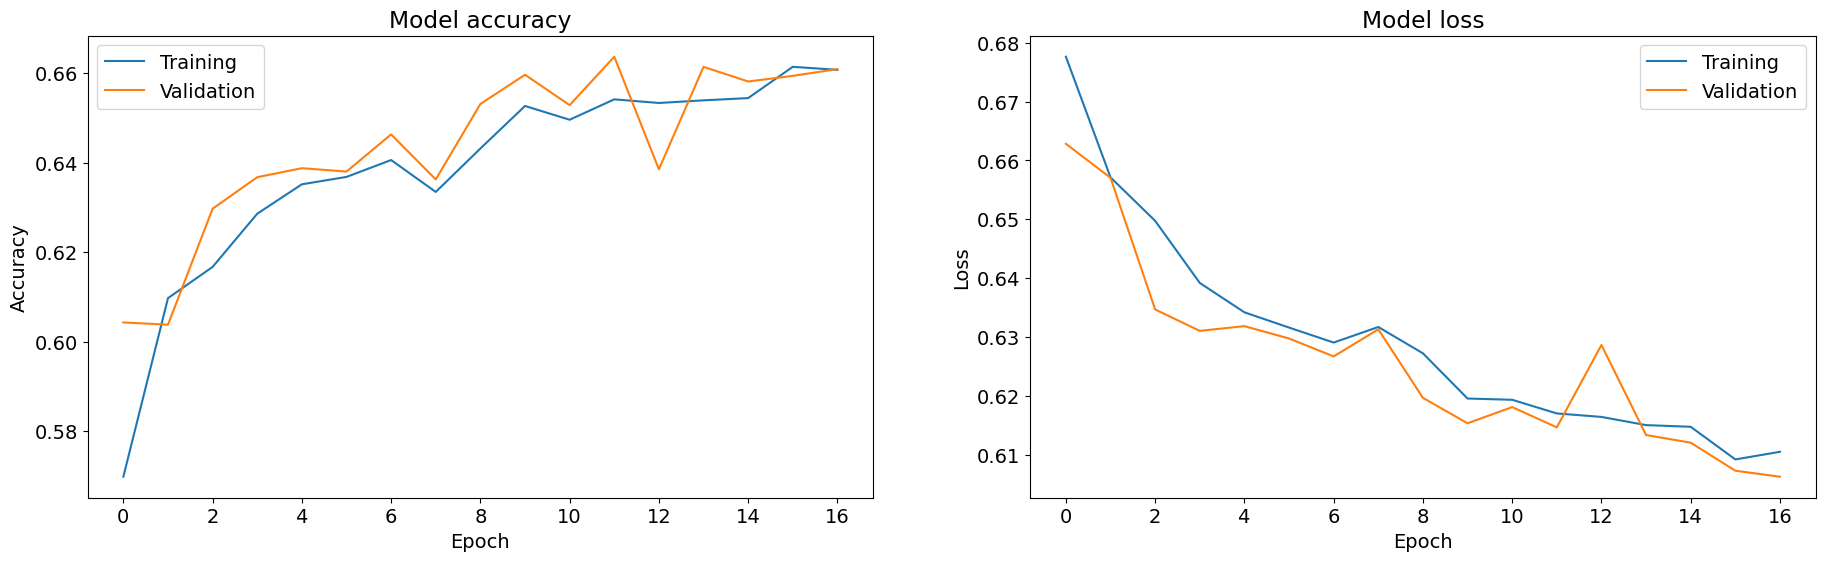

In [60]:
fig, ax = plt.subplots(1, 2, figsize = (18, 6))
fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

plt.rcParams.update({'font.size': 14})

# plot training & validation accuracy values
ax[0].plot(history.history['accuracy'], label = 'Training')
ax[0].plot(history.history['val_accuracy'], label = 'Validation')
ax[0].set_title('Model accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend()

# summarize history for loss
ax[1].plot(history.history['loss'], label = 'Training')
ax[1].plot(history.history['val_loss'], label = 'Validation')
ax[1].set_title('Model loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend()

BUILD DEEP LEARNING NETWORKS. EXPLORE OTHER CNN OPTIONS!!!
https://www.kaggle.com/code/stoicstatic/twitter-sentiment-analysis-using-word2vec-bilstm

FastTextWord embedding with Gensim 
https://towardsdatascience.com/word-embedding-with-word2vec-and-fasttext-a209c1d3e12c

word2vec web:
https://www.districtdatalabs.com/modern-methods-for-sentiment-analysis#:~:text=Word2Vec%20Example%20in%20Python&text=It's%20clear%20from%20the%20above,in%20our%20case%20sentiment%20analysis

https://www.askpython.com/python-modules/gensim-word2vec

word2vec + NN: 
https://medium.com/analytics-vidhya/analyzing-tweets-semantic-using-word-embedding-9463e6fbeadb

text classification with tf-idf, word2vec n BERT
https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794



In [67]:
training_model = load_model('ltsm_model.h5')

In [68]:
training_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 60, 300)           18000000  
                                                                 
 bidirectional_4 (Bidirectio  (None, 60, 200)          320800    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 60, 200)          240800    
 nal)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 56, 100)           100100    
                                                                 
 global_max_pooling1d_2 (Glo  (None, 100)              0         
 balMaxPooling1D)                                                
                                                   

In [104]:
training_model.load_weights('ltsm_model_weights.h5')

### Evaluate model 

In [69]:
# eval model on test data 
score = training_model.evaluate(X_test, y_test)

311/311 [==============================] - 85s 235ms/step - loss: 0.6031 - accuracy: 0.6630


In [70]:
# find predicted probabiltiies on test data
y_proba_ltsm = training_model.predict(X_test)

311/311 [==============================] - 83s 221ms/step


In [76]:
# convert probabilities to class labels (predictions label)
y_pred_ltsm = np.where(y_proba_ltsm>0.5, 1, 0)
y_pred_lstm

array([[0],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]])

              precision    recall  f1-score   support

           0       0.65      0.72      0.68      5012
           1       0.68      0.61      0.64      4925

    accuracy                           0.66      9937
   macro avg       0.66      0.66      0.66      9937
weighted avg       0.66      0.66      0.66      9937

LSTM accuracy:  66.2977
LSTM f1:  0.6415


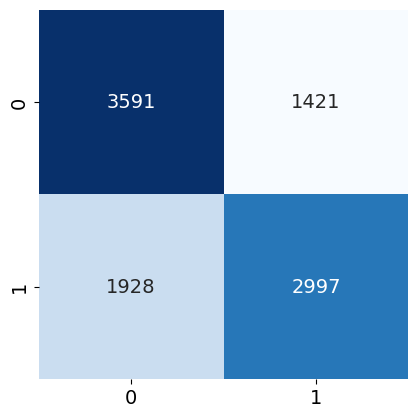

In [77]:
# find confusion matrix
mat = confusion_matrix(y_pred_ltsm, y_test)

# confusion matrix
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='Blues')

# classification report
print(classification_report(y_test, y_pred_ltsm))

# find accuracy
LSTM_accuracy = score[1]*100
print('LSTM accuracy: ', round(LSTM_accuracy, 4))

# find f1 score
LSTM_f1 = f1_score(y_test, y_pred_ltsm)
print('LSTM f1: ', round(LSTM_f1, 4))

Text(0.5, 1.0, 'PR Curve (AUC-PR = 0.61)')

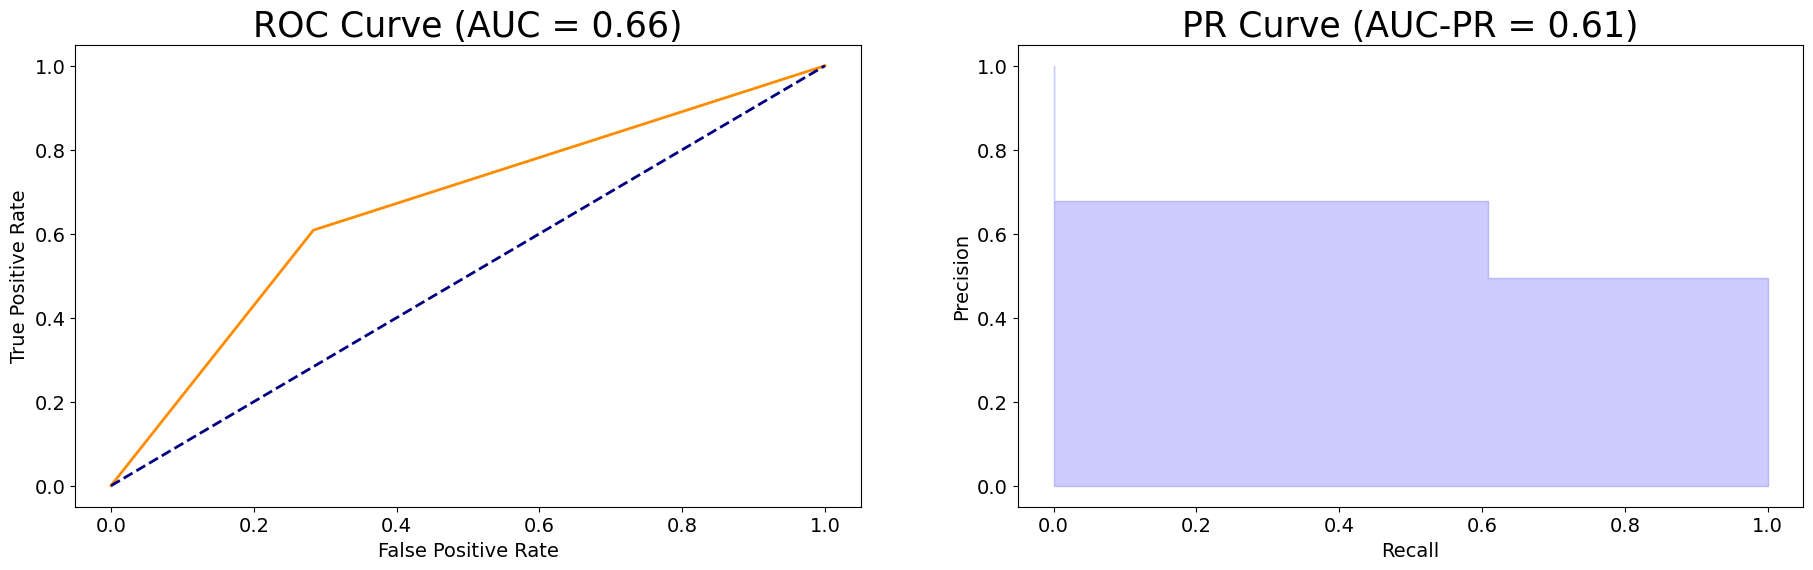

In [78]:
# set plots up
fig, ax = plt.subplots(1, 2, figsize = (18, 6))
fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

# cal fpr, tpr 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_ltsm)
auc = roc_auc_score(y_test, y_pred_ltsm)

# cal auc-pr
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_ltsm)
auc_pr = average_precision_score(y_test, y_pred_ltsm)

# auc
ax[0].plot(fpr, tpr, color='darkorange', lw=2)
ax[0].plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('ROC Curve (AUC = %0.2f)' % auc, fontsize=25)

# precision/recall
step_kwargs= {'step': 'post'}
ax[1].fill_between(recall, precision, alpha=0.2, color = 'b', **step_kwargs)
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('PR Curve (AUC-PR = %0.2f)' % auc_pr, fontsize=25)

In [34]:
# generate predictions on new data with 3 samples
print('Generate predictions with 3 samples: ')
predictions = training_model.predict(X_test[:3])
print("Predictions shape:", predictions.shape)

Generate predictions with 3 samples: 
1/1 [==============================] - 0s 170ms/step
Predictions shape: (3, 1)


####  do i want to do gridsearchCV? 
https://github.com/tirthajyoti/Deep-learning-with-Python/blob/master/Notebooks/Keras_Scikit_Learn_wrapper.ipynb

## Evaluate model metrics 

### Predictions with new dataset on starbucks

https://www.kaggle.com/code/sreelalh/sentiment-analysis-nothing-phone-related-tweets/notebook

SIA score:
https://www.analyticsvidhya.com/blog/2021/07/performing-sentiment-analysis-using-twitter-data/

In [79]:
# use Twitter API 
sb = pd.read_csv('../projects/sblabelled.csv')

In [80]:
sb

,text_str,sentiment_score,Sentiment,SIA_label
0,shooters lucida guy also commission starbucks ...,-0.4404,Negative,-1
1,fumbled hard hire please hire,0.2263,Positive,1
2,somebody probably told starbucks drive thru mi...,-0.3400,Negative,-1
3,jungles red tape keys truck vent starbucks cup...,0.0000,Neutral,0
4,cryptolab x dalgomz x starbucks try airdrop ev...,0.0000,Neutral,0
5,solidarity partners hwy amp brinkley hill star...,0.2960,Positive,1
6,starbucks customize journey set,0.0000,Neutral,0
7,skip starbucks today join instead give dick love,0.4767,Positive,1
8,nervous apply job like barnstar store glasgow ...,0.4215,Positive,1
9,true di ako ready miya sa starbucks ng med city,0.6486,Positive,1


In [149]:
df= sb[['text_str']]
df

,text_str
0,shooters lucida guy also commission starbucks ...
1,fumbled hard hire please hire
2,somebody probably told starbucks drive thru mi...
3,jungles red tape keys truck vent starbucks cup...
4,cryptolab x dalgomz x starbucks try airdrop ev...
5,solidarity partners hwy amp brinkley hill star...
6,starbucks customize journey set
7,skip starbucks today join instead give dick love
8,nervous apply job like barnstar store glasgow ...
9,true di ako ready miya sa starbucks ng med city


In [174]:
# Define a function to apply to each row of the dataframe
def apply_sentiment(row):
    sentence = row['text_str']
    label, probability = predict_sentiment(sentence)
    row['predicted_sentiment'] = label
    row['predicted_probability'] = probability[0][0]
    return row

# Apply the function to each row of the dataframe
df = df.apply(apply_sentiment, axis=1)

1/1 [==============================] - 0s 48ms/step


In [187]:
df

,text_str,predicted_sentiment,predicted_probability
0,shooters lucida guy also commission starbucks ...,negative,0.199491
1,fumbled hard hire please hire,negative,0.346945
2,somebody probably told starbucks drive thru mi...,positive,0.511723
3,jungles red tape keys truck vent starbucks cup...,negative,0.209821
4,cryptolab x dalgomz x starbucks try airdrop ev...,positive,0.648808
5,solidarity partners hwy amp brinkley hill star...,positive,0.817075
6,starbucks customize journey set,positive,0.608999
7,skip starbucks today join instead give dick love,negative,0.457197
8,nervous apply job like barnstar store glasgow ...,negative,0.360738
9,true di ako ready miya sa starbucks ng med city,negative,0.325192


In [155]:
df['predicted_label'].count

<bound method Series.count of 0     negative
1     negative
2     positive
3     negative
4     positive
5     positive
6     positive
7     negative
8     negative
9     negative
10    negative
11    negative
12    positive
13    negative
14    positive
15    positive
16    positive
17    negative
18    positive
19    negative
20    positive
21    negative
22    positive
23    positive
24    positive
25    positive
26    positive
27    positive
28    negative
29    positive
30    negative
31    negative
32    negative
33    negative
34    negative
35    negative
36    negative
37    negative
38    negative
39    negative
40    negative
41    negative
42    negative
Name: predicted_label, dtype: object>

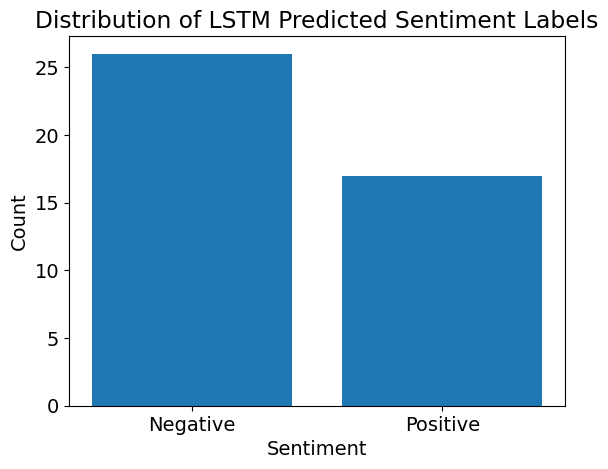

In [157]:
# get count of each predicted label
unique_labels, counts = np.unique(df['predicted_label'], return_counts=True)

# plot bar chart for visualisations
plt.bar(unique_labels, counts)
plt.xticks(unique_labels, ['Negative', 'Positive'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of LSTM Predicted Sentiment Labels')
plt.show()

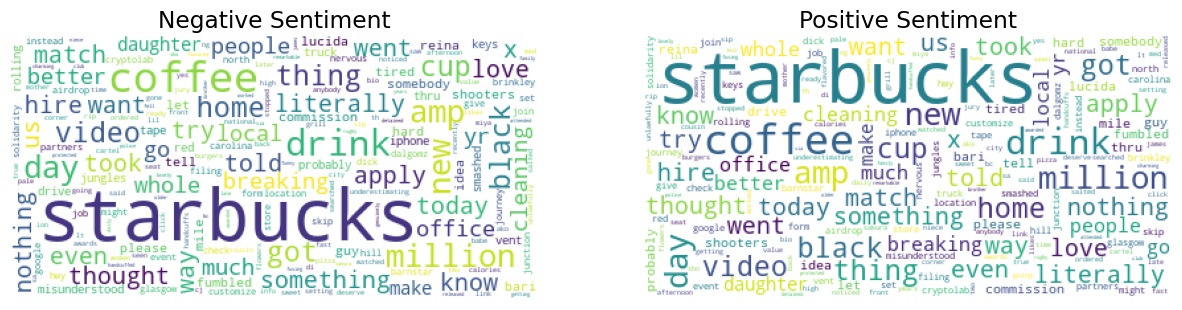

In [192]:
# Get most common words in predicted sentiment label
data_neg = df[df.predicted_sentiment=='Negative']
neg_words = ' '.join([word for word in df['text_str']])
data_pos = df[df.predicted_sentiment=='Positive']
pos_words = ' '.join([word for word in df['text_str']])

# Create word clouds
pos_cloud = WordCloud(background_color='white').generate(pos_words)
neg_cloud = WordCloud(background_color='white').generate(neg_words)

# Plot word clouds
fig, axes = plt.subplots(1, 2, figsize=(15, 10))
axes[0].imshow(neg_cloud)
axes[0].set_title('Negative Sentiment')
axes[0].axis('off')
axes[1].imshow(pos_cloud)
axes[1].set_title('Positive Sentiment')
axes[1].axis('off')
plt.show()